In [9]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

path = "./images"

workers = 3
batch_size = 64
image_size = 128
nz = 100
num_epochs = 10
lr = 0.001
beta1 = 0.5
data = torchvision.datasets.ImageFolder(root=path,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

def imshow(image):
    npimage = (image / 2 + 0.5).numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    device = torch.device("mps")

netD = Discriminator().to(device)
netG = Generator().to(device)
netD.apply(initialize_weights)
netG.apply(initialize_weights)
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Function to plot results
def plot_results(G_losses, D_losses):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="Generator")
    plt.plot(D_losses, label="Discriminator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [11]:
img_list = []
G_losses = []
D_losses = []
iters = 0

import time

start_time = time.time()

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)
        netD.zero_grad()
        real_images = real_images.to(device)
        output_real = netD(real_images).squeeze()
        loss_real = criterion(output_real, real_labels)
        loss_real.backward()
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        output_fake = netD(fake_images.detach()).squeeze()
        loss_fake = criterion(output_fake, fake_labels)
        loss_fake.backward()
        optimizerD.step()
        D_loss = loss_real + loss_fake
        netG.zero_grad()
        output_fake_for_update = netD(fake_images).squeeze()
        G_loss = criterion(output_fake_for_update, real_labels)
        G_loss.backward()
        optimizerG.step()
        if i % 50 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                  f'Loss D: {D_loss:.4f}, Loss G: {G_loss:.4f} '
                  f'D(x): {output_real.mean().item():.4f}, '
                  f'D(G(z)): {output_fake.mean().item():.4f} / {output_fake_for_update.mean().item():.4f}')
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        if (i + 1) % 500 == 0 or (epoch == num_epochs - 1 and i == len(dataloader) - 1):
            with torch.no_grad():
                fixed_fake_images = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fixed_fake_images, padding=2, normalize=True))
        iters += 1
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Epoch [0/10] Batch [0/401] Loss D: 1.6393, Loss G: 3.7533 D(x): 0.3696, D(G(z)): 0.3506 / 0.0313
Epoch [0/10] Batch [50/401] Loss D: 0.7452, Loss G: 21.0625 D(x): 0.9825, D(G(z)): 0.3688 / 0.0000
Epoch [0/10] Batch [100/401] Loss D: 0.0600, Loss G: 14.0186 D(x): 0.9517, D(G(z)): 0.0004 / 0.0000
Epoch [0/10] Batch [150/401] Loss D: 0.0912, Loss G: 9.2915 D(x): 0.9313, D(G(z)): 0.0086 / 0.0002
Epoch [0/10] Batch [200/401] Loss D: 0.1487, Loss G: 5.3084 D(x): 0.9102, D(G(z)): 0.0411 / 0.0055
Epoch [0/10] Batch [250/401] Loss D: 0.6810, Loss G: 26.4758 D(x): 0.9772, D(G(z)): 0.4501 / 0.0000
Epoch [0/10] Batch [300/401] Loss D: 0.0867, Loss G: 5.9208 D(x): 0.9635, D(G(z)): 0.0445 / 0.0029
Epoch [0/10] Batch [350/401] Loss D: 0.1934, Loss G: 7.7895 D(x): 0.8638, D(G(z)): 0.0060 / 0.0012
Epoch [0/10] Batch [400/401] Loss D: 0.3240, Loss G: 8.6935 D(x): 0.9746, D(G(z)): 0.2281 / 0.0007
Epoch [1/10] Batch [0/401] Loss D: 0.4014, Loss G: 5.5176 D(x): 0.7542, D(G(z)): 0.0071 / 0.0120
Epoch [1/10]

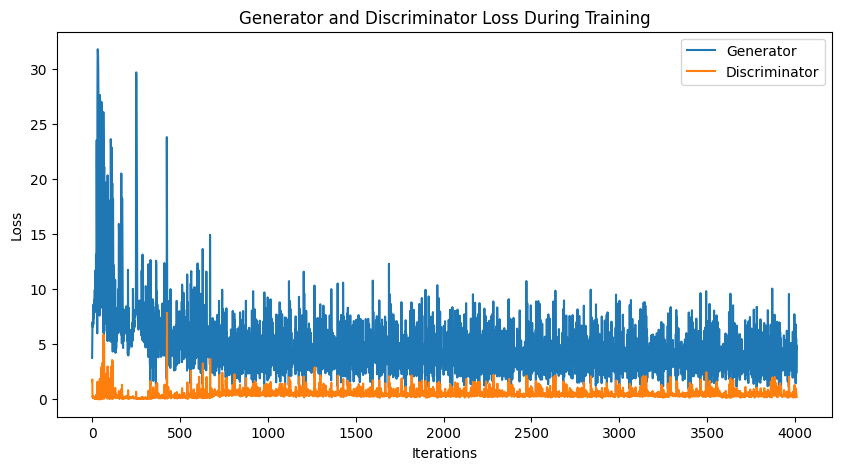

In [12]:
plot_results(G_losses,D_losses)

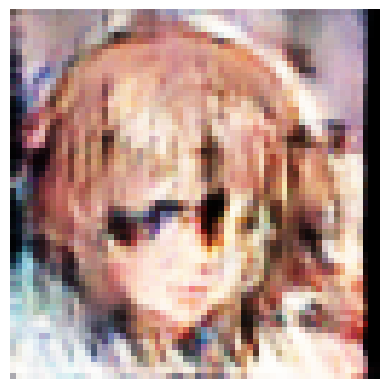

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
noise = torch.randn(1, nz, 1, 1, device=device)
fake_image = netG(noise)
fake_image = (fake_image.to("cpu").clone().detach().squeeze(0).numpy().transpose(1, 2, 0) + 1) / 2
fake_image = np.clip(fake_image, 0, 1)
plt.imshow(fake_image)
plt.axis('off')
plt.show()


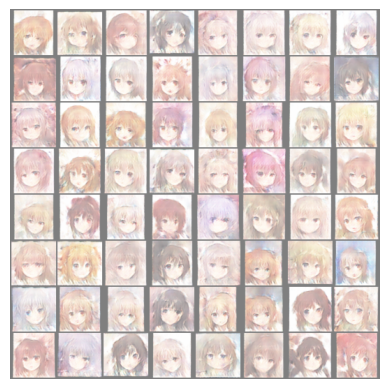

In [14]:
fake_image = img_list[0]
fake_image = (fake_image.to("cpu").clone().detach().squeeze(0).numpy().transpose(1, 2, 0) + 1) / 2
fake_image = np.clip(fake_image, 0, 1)
plt.imshow(fake_image)
plt.axis('off')
plt.show()